# GridPalette

> Class for the (Square) BivariateGridPalette. 
    
Default is a 3x3 Grid with a `blues2red` color scheme. `grid_size` (N in the NxN grid) is to match the number of cuts in data

Predefined palettes can be generated with `BivariateGridPalette.from_dropdown()`
    
If you have a upper left, lower right and upper right color users can use `BivariateGridPalette.from_list(upper_left_color, lower_right_color, upper_right_color)` (can be as arguments or an iterable)
    
    
Users can use a color picker (though not recommended):
1. Picking a single color: `BivariateGridPalette.from_picker()`
2. Picking the corner colors: `BivariateGridPalette.from_pickers_3()`

In [ ]:
#| default_exp grid_palette

In [ ]:
#| hide
from nbdev.showdoc import *

In [ ]:
#| export
import matplotlib.colors as mcolors
import numpy as np
import matplotlib.pyplot as plt
from typing import Iterable, Union, Optional
import ipywidgets as widgets
import re
import math
from string import ascii_uppercase


In [ ]:
#| export
letters = list(ascii_uppercase) + [j+i for j in ascii_uppercase for i in ascii_uppercase]

In [ ]:
#| export
class GridPalette:
    f"Base class for GridPalettes. Max grid size is currently {len(letters)}"
    def __init__(self, color_list):
        color_matrix = color_list_to_matrix(color_list)
        self.color_list = color_list
        self.color_matrix = color_matrix
        self.cmap = mcolors.ListedColormap(self.color_list)
        
    @staticmethod
    def color_list_to_matrix(color_list):
        "Take a list of colors and return a NxN matrix of colors"
        lsqrt = math.sqrt(len(color_list))
        if lsqrt*lsqrt != len(color_list):
            raise ValueError("Length of color list is not square.")
        if lsqrt > len(letters):
            raise ValueError("Grid size exceeds max size: 26")
        if any([mcolors.is_color_like(c)==False for c in color_list]):
            color_list = [mcolors.to_rgb(c) for c in color_list]
        N = int(lsqrt)
        return np.array([[color_list[x] for x in range(y*N, (y+1)*N)] for y in reversed(range(N))])
    
    def show_grid(self):
        plt.imshow(self.color_matrix)
        plt.yticks(list(range(self.grid_size)), [x+1 for x in reversed(range(self.grid_size))])
        plt.xticks(list(range(self.grid_size)), [letters[i] for i in range(self.grid_size)])

    def __repr__(self):
        self.show_grid()
        return f'BivariateGridPalette {self.palette_name}'

In [ ]:
#| export
class BivariateGridPalette(GridPalette):
    """
    Class for the Palette. Creates a grid_size x grid_size matrix of colors from the inputed corner colors
    """

    start_color = '#e8e8e8'
    # this contains the reccomended palettes
    bivar_color_dict = {
        'blues2reds':['#64acbe', '#c85a5a','#574249'],
        'purple2gold':['#9972af','#c8b35a','#804d36'],
        'purple2cyan':['#be64ac','#5ac8c8','#3b4994'],
        'green2blue':['#4b6e88','#73ae80','#2a5a5b']
        }

    def __init__(self, 
                 palette_name:str='blues2reds', 
                 grid_size:int=3, 
                 upper_left_color:Optional[Union[str, tuple]]=None, 
                 lower_right_color:Optional[Union[str, tuple]]=None, 
                 upper_right_color:Optional[Union[str, tuple]]=None):
        
        self.grid_size=grid_size
        if palette_name not in BivariateGridPalette.bivar_color_dict.keys():
            none_colors = [c for c in [upper_left_color, lower_right_color, upper_right_color] if c is None]
            if len(none_colors)>0:
                print(none_colors)
                raise ValueError(f'If palette_name is not in palette names, colors must be provided. \n Palette names: {" ,".join(BivariateGridPalette.bivar_color_dict.keys())}')
            else:
                self.palette_name=palette_name
                self._update_from_colors(upper_left_color, lower_right_color, upper_right_color)
        else:
            self.palette_name=palette_name
            self._update_from_name()
        
    def _set_properties(self):
        self.color_matrix, self.color_list = self.get_bivar_cmap(color1 = self.upper_left_color,
                                                                 color2 = self.lower_right_color, 
                                                                 color3 = self.upper_right_color,
                                                                 N = self.grid_size,
                                                                 start_color = BivariateGridPalette.start_color)
        self.cmap = mcolors.ListedColormap(self.color_list, name=self.palette_name)

    def _update_from_name(self):
        self.upper_left_color, self.lower_right_color, self.upper_right_color = BivariateGridPalette.bivar_color_dict[self.palette_name]
        self._set_properties()
    
    def resize(self, new_grid_size):
        self.grid_size = new_grid_size
        self._set_properties()
    
    @staticmethod 
    def color_unpack(*colors):
        if any([c is None for c in colors[1:]]) or len(colors)==1:
            color_ret = tuple(colors[0])
        elif len(colors)>3 or len(colors)==2:
            raise ValueError("Exactly three colors must be entered")
        else:
            color_ret = tuple(colors)
        invalid_colors = [c for c in color_ret if mcolors.is_color_like(c) == False]
        if len(invalid_colors)>0:
            raise ValueError(f"Not all inputted colors are valid. Invalid colors: {invalid_colors}")
        return color_ret

    def _update_from_colors(self, upper_left_color, lower_right_color=None, upper_right_color=None):
        upper_left_color, lower_right_color, upper_right_color = BivariateGridPalette.color_unpack(upper_left_color, lower_right_color, upper_right_color)
        self.upper_left_color = upper_left_color 
        self.lower_right_color = lower_right_color
        self.upper_right_color = upper_right_color
        self._set_properties()


    @staticmethod
    def get_bivar_cmap(color1, #upper left color
                       color2, #lower right color
                       color3, #upper right color
                       N, #grid size
                       start_color):
        "Function create color matrix and color list from upper left, lower right and upper right colors."
        col1_cmap = mcolors.LinearSegmentedColormap.from_list('col1_cmap', [start_color, color1], N=N)
        row1_cmap = mcolors.LinearSegmentedColormap.from_list('row1_cmap', [start_color, color2], N=N)
        rowN_cmap = mcolors.LinearSegmentedColormap.from_list('rowN_cmap', [color1, color3], N=N)
        colN_cmap = mcolors.LinearSegmentedColormap.from_list('colN_cmap', [color2, color3], N=N)

        divisors = np.linspace(0,1,N)
        middle_cmaps = [
            mcolors.LinearSegmentedColormap.from_list(f'row{i}_cmap', 
                                                    [col1_cmap(div), colN_cmap(div)], 
                                                    N=N) 
            for i, div in enumerate(divisors[1:N-1], 1)
        ]
        cmaps = [row1_cmap] + middle_cmaps + [rowN_cmap]
        colors = [cmap(div) for cmap in cmaps for div in divisors]

        color_matrix = BivariateGridPalette.color_list_to_matrix(colors)
        return color_matrix, colors
    
    def get_color_dict(self, mode='hex'):
        "Function to the corner colors from the Grid"
        if mode=='hex':
            color1, color2, color3 = [mcolors.to_hex(c) for c in [self.upper_left_color, self.lower_right_color, self.upper_right_color]]
        elif mode=='rgb':
            color1, color2, color3 = [mcolors.to_rgb(c) for c in [self.upper_left_color, self.lower_right_color, self.upper_right_color]]
        else:
            raise NotImplementedError('other color dict types are not implemented yet')
        return {self.palette_name: [color1,color2,color3]}


the representation of the grid palette is the imshow of the color matrix

BivariateGridPalette blues2reds

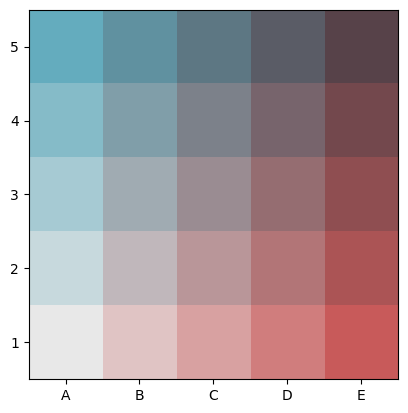

In [ ]:
gp = BivariateGridPalette(grid_size=5)
gp

you can resize grid palettes with `gp.resize(new_size)`

BivariateGridPalette blues2reds

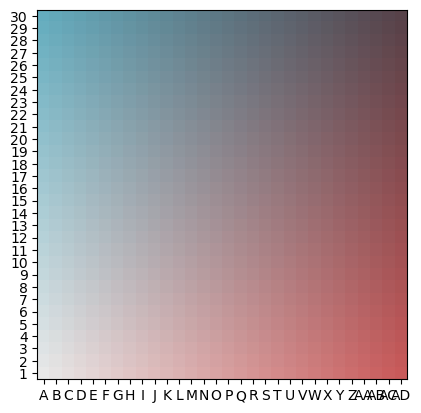

In [ ]:
gp.resize(30)
assert len(gp.color_list) == 900
gp

## Generating Palettes

In [ ]:
#| export
@staticmethod
def from_list(upper_left_color, 
              lower_right_color=None, 
              upper_right_color=None, 
              palette_name='from_list',
             grid_size=3):
    "Generate a BivariateGridPalette from inputted corner colors"
    upper_left_color, lower_right_color, upper_right_color = BivariateGridPalette.color_unpack(upper_left_color, lower_right_color, upper_right_color)
    return BivariateGridPalette(palette_name=palette_name,
                       upper_left_color=upper_left_color,
                       lower_right_color=lower_right_color,
                       upper_right_color=upper_right_color,
                       grid_size=grid_size
                      )

BivariateGridPalette.from_list = from_list


In [ ]:
gp = BivariateGridPalette.from_list('#9972af','#c8b35a','#804d36')

assert len(gp.color_list) == 9
gp = BivariateGridPalette.from_list(['#9972af','#c8b35a','#804d36'], grid_size=4)
assert len(gp.color_list) == 16

In [ ]:
#| export
@staticmethod
def from_dropdown():
    "Select BivariateGridPalette from dropdown list"
    gp = BivariateGridPalette()
    
    @widgets.interact
    def choose_palette(name=list(BivariateGridPalette.bivar_color_dict.keys()), 
                       grid_size=widgets.IntSlider(min=2, max=10, step=1, value=3, description="Grid Size:")):
        
        gp.palette_name=name
        gp.grid_size=grid_size
        gp._update_from_name()
        gp.show_grid()

    return gp

BivariateGridPalette.from_dropdown = from_dropdown

In [ ]:
#| hide
class BivariateGridPaletteRegistry(mcolors.ColorSequenceRegistry):
    "TODO: Registry for the premade grid palettes. "
    _BUILTIN_GRID_PALETTES = {
        'blues2reds':BivariateGridPalette(palette_name='blues2reds'),
        'purple2gold':BivariateGridPalette(palette_name='purple2gold'),
        'purple2cyan':BivariateGridPalette(palette_name='purple2cyan'),
        'green2blue':BivariateGridPalette(palette_name='green2blue')
        }
    def __init__(self): self._color_sequences = {**self._BUILTIN_GRID_PALETTES}
    def __getitem__(self,item): return self._color_sequences[item]

    def register(self, grid_palette):
        if grid_palette.palette_name in self._BUILTIN_GRID_PALETTES.keys():
            raise ValueError(f"{name!r} is a reserved name for a builtin "
                             "color sequence")
        color_list = list(grid_palette.color_list)  # force copy and coerce type to list
        for color in color_list:
            try:
                mcolors.to_rgba(color)
            except ValueError:
                raise ValueError(
                    f"{color!r} is not a valid color specification")
        self._color_sequences[grid_palette.palette_name] = grid_palette

    
_gp_registry = BivariateGridPaletteRegistry()


In [ ]:
#| export
#| hide
def darken_blend(top_left_color, bottom_right_color):
    "Function to blend colors for top right color"
    # do we need a check here?
    top_left_color = mcolors.to_rgb(top_left_color)
    bottom_right_color = mcolors.to_rgb(bottom_right_color)
    return tuple([min(c1,c2) for c1, c2 in zip(top_left_color, bottom_right_color)])

def split_complimentary_colors(color):
    rgb = mcolors.to_rgb(color)
    h,s,v = mcolors.rgb_to_hsv(rgb)
    h += 1
    h0 = h + 30/180
    h1 = h - 30/180
    return mcolors.hsv_to_rgb((h0,s,v)),mcolors.hsv_to_rgb((h1,s,v))

def hex_to_hsv(color): return mcolors.rgb_to_hsv(mcolors.to_rgb(color))

def get_opposite_color(color, degree=180):
    h,s,v = hex_to_hsv(color)
    #TODO: change degree? Should this whole method be replaced?
    hnew = ((360*h)-degree)/360
    return mcolors.hsv_to_rgb([hnew,s,v])

In [ ]:
#| export
_blend_modes = {
    'darken':darken_blend
}

def from_picker(mode='darken'):
    "BivariateGridPalette from a single color picker"
    gp = BivariateGridPalette()
    blend_mode = _blend_modes.get(mode, 'Not Implemented')
    if blend_mode=='Not Implemented': raise NotImplementedError(f"Only blend modes implemented are: {' '.join(_blend_modes.keys())}")
    
    #TODO: add a degree slider: degree=widgets.IntSlider(min=1, max=359, step=1, value=180, description="Degree:"),
    @widgets.interact
    def choose_top_left_color(upper_left_color=widgets.ColorPicker(value=gp.upper_left_color), #Color selected from picker
                              grid_size=widgets.IntSlider(min=2, max=10, step=1, value=3, description="Grid Size:"), #Size of grid (N)
                              palette_name='from_picker' #User selected name.
                             ):
        
        lower_right_color = get_opposite_color(upper_left_color)
        upper_right_color = blend_mode(upper_left_color, lower_right_color)
        gp.palette_name=palette_name
        gp.grid_size=grid_size
        gp._update_from_colors(upper_left_color,lower_right_color,upper_right_color)
        gp.show_grid()
    return gp

BivariateGridPalette.from_picker = from_picker



In [ ]:
gp = from_picker()

interactive(children=(ColorPicker(value='#64acbe', description='upper_left_color'), IntSlider(value=3, descrip…

In [ ]:
#| export
def from_pickers_3():
    "BivariateGridPalette from three color pickers"
    
    gp = BivariateGridPalette()
    @widgets.interact
    def choose_three_colors(upper_left_color=widgets.ColorPicker(value=gp.upper_left_color),
                            lower_right_color=widgets.ColorPicker(value=gp.lower_right_color),
                            upper_right_color=widgets.ColorPicker(value=gp.upper_right_color),
                            grid_size=widgets.IntSlider(min=2, max=10, step=1, value=3, description="Grid Size:"),
                            palette_name='from_picker'):
    
        gp.grid_size = grid_size
        gp.palette_name=palette_name
        gp._update_from_colors(upper_left_color,lower_right_color,upper_right_color)
        gp.show_grid()
    
    return gp

BivariateGridPalette.from_picker = from_picker


In [ ]:
gp = from_pickers_3()

interactive(children=(ColorPicker(value='#64acbe', description='upper_left_color'), ColorPicker(value='#c85a5a…

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()